In [23]:
import os
import torch
import numpy as np
import pandas as pd
import rootutils

rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)

import src.data.defile_datamodule
from src.data.defile_datamodule import DefileDataModule

In [24]:
import importlib

importlib.reload(src.data.defile_datamodule)
from src.data.defile_datamodule import DefileDataModule

In [25]:
dataloader = DefileDataModule(
    data_dir=r"../data",
    species="Common Buzzard",
    era5_main_location="Defile",
    era5_main_variables=[
        "temperature_2m",
        "total_precipitation",
        "surface_pressure",
        "u_component_of_wind_10m",
        "v_component_of_wind_10m",
    ],
    era5_hourly_locations=[
        "MontTendre",
    ],
    era5_hourly_variables=[
        "temperature_2m",
        "total_precipitation",
        "surface_pressure",
        "u_component_of_wind_10m",
        "v_component_of_wind_10m",
    ],
    era5_daily_locations=[
        "Defile",
    ],
    era5_daily_variables=[
        "temperature_2m",
        "total_precipitation",
        "surface_pressure",
        "u_component_of_wind_10m",
        "v_component_of_wind_10m",
    ],
    years=range(2003, 2024),
    doy=(196, 335),
    lag_day=7,
    forecast_day=5,
    train_val_test_cum_ratio=[1, 1],
    train_val_test="none",
    year_used="none",
)

Fetching hourly ERA5 data on disk for ['Defile']...


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Fetching hourly ERA5 data on disk for ['MontTendre']...


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Fetching hourly ERA5 data on disk for ['Defile']...


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


In [26]:
train_dataloader = dataloader.train_dataloader()
count = train_dataloader.dataset.count

In [10]:
count

,date,start,end,count,duration,count_raw,doy,year,year_period,year_used,tvt,year_used_trans,doy_trans
0,2003-07-15,2003-07-15 07:50:00+00:00,2003-07-15 14:00:00+00:00,0.0,6.166667,0.0,196,2003,2100,2003,train,0.03,0.035519
1,2003-07-16,2003-07-16 07:55:00+00:00,2003-07-16 12:30:00+00:00,0.0,4.583333,0.0,197,2003,2100,2003,train,0.03,0.038251
2,2003-07-17,2003-07-17 08:00:00+00:00,2003-07-17 14:30:00+00:00,0.0,6.500000,0.0,198,2003,2100,2003,train,0.03,0.040984
3,2003-07-18,2003-07-18 08:00:00+00:00,2003-07-18 14:00:00+00:00,0.0,6.000000,0.0,199,2003,2100,2003,train,0.03,0.043716
4,2003-07-19,2003-07-19 08:00:00+00:00,2003-07-19 14:00:00+00:00,0.0,6.000000,0.0,200,2003,2100,2003,train,0.03,0.046448
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13810,2023-11-23,2023-11-23 10:30:00+00:00,2023-11-23 11:00:00+00:00,0.0,0.500000,0.0,327,2023,2200,2023,train,0.23,0.393443
13811,2023-11-23,2023-11-23 11:00:00+00:00,2023-11-23 12:00:00+00:00,7.0,1.000000,7.0,327,2023,2200,2023,train,0.23,0.393443
13812,2023-11-23,2023-11-23 12:00:00+00:00,2023-11-23 13:00:00+00:00,24.0,1.000000,24.0,327,2023,2200,2023,train,0.23,0.393443
13813,2023-11-23,2023-11-23 13:00:00+00:00,2023-11-23 14:00:00+00:00,4.0,1.000000,4.0,327,2023,2200,2023,train,0.23,0.393443


In [27]:
overlaps = []
for i in range(1, len(count)):
    if (
        count["start"].iloc[i] < count["end"].iloc[i - 1]
    ):  # Check if current start is before previous end
        overlaps.append((i - 1, i))

# Extract the rows that have overlaps
overlapping_rows = set()
for pair in overlaps:
    overlapping_rows.update(pair)

# Filter the DataFrame to show only the overlapping rows
count.iloc[list(overlapping_rows)]

,date,start,end,count,duration,count_raw,doy,year,year_period,year_used,tvt,year_used_trans,doy_trans


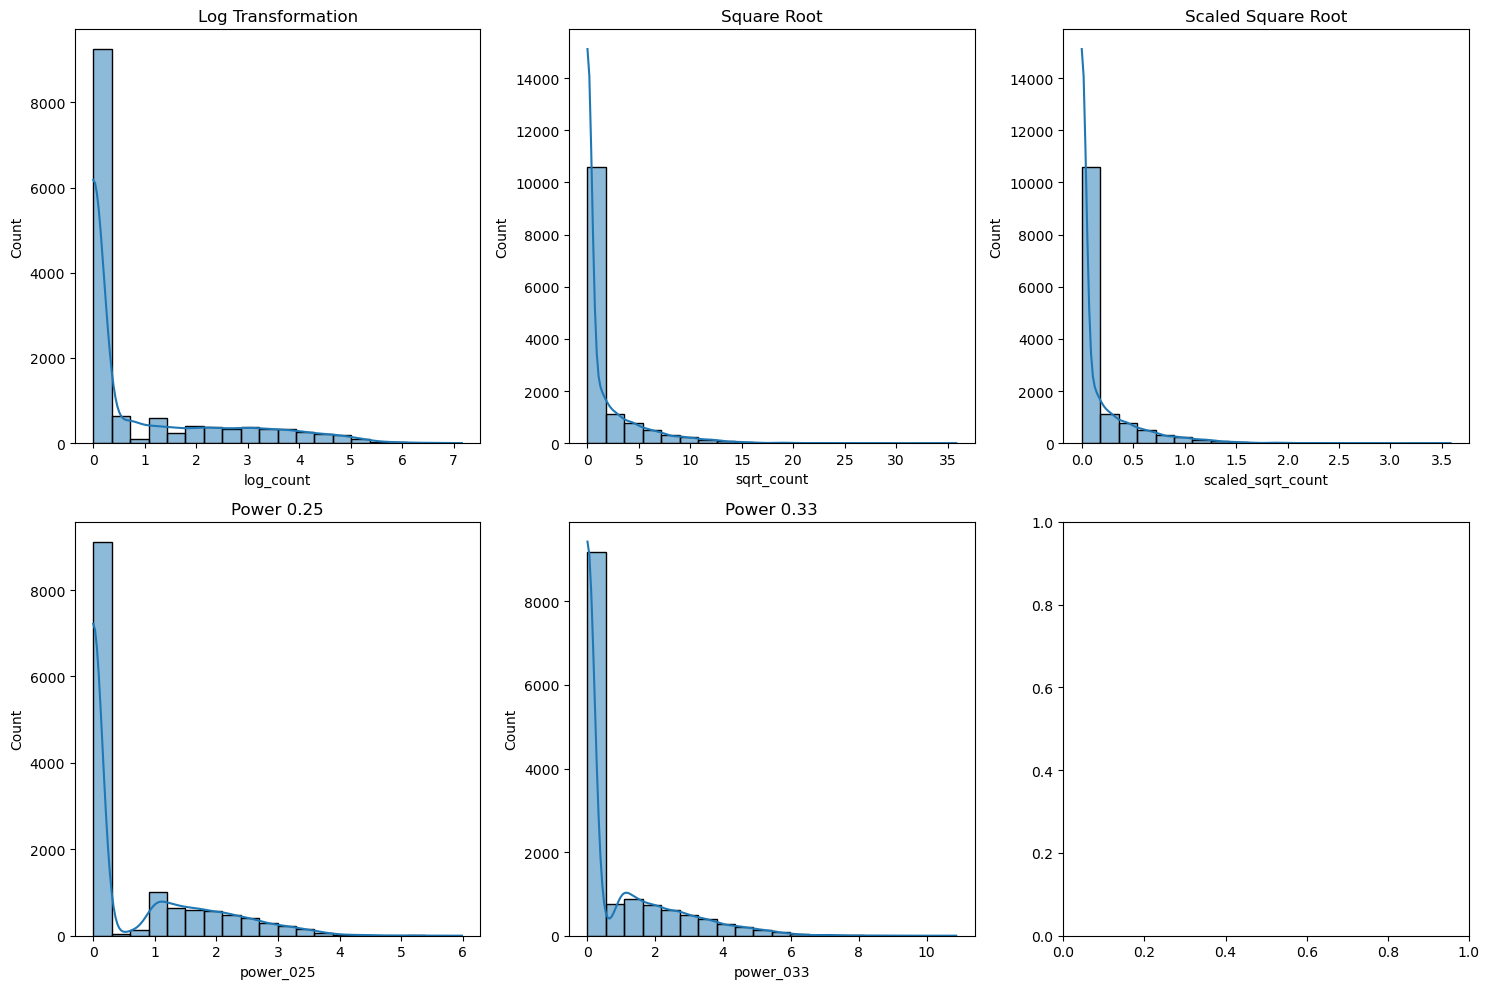

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

count = train_dataloader.dataset.count

# Apply transformations
count["log_count"] = np.log1p(count["count"])  # log(1 + x)
count["sqrt_count"] = np.sqrt(count["count"])
count["scaled_sqrt_count"] = np.sqrt(count["count"]) / 10
count["power_025"] = count["count"] ** 0.25
count["power_033"] = count["count"] ** (1 / 3)

# Plot all transformations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

transformations = [
    ("Log Transformation", "log_count"),
    ("Square Root", "sqrt_count"),
    ("Scaled Square Root", "scaled_sqrt_count"),
    ("Power 0.25", "power_025"),
    ("Power 0.33", "power_033"),
]

for ax, (title, col) in zip(axes.flatten(), transformations):
    sns.histplot(count[col], bins=20, kde=True, ax=ax)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [338]:
train_dataloader.dataset.return_original = True
count, yr, doy, era5_main, era5_hourly, era5_daily, mask = train_dataloader.dataset[1]
t = era5_main.copy()

In [339]:
train_dataloader.dataset.era5_main.surface_pressure

<xarray.DataArray 'surface_pressure' (date: 4602, time: 24, location: 1)>
array([[[0.77832656],
        [0.70718864],
        [0.72408881],
        ...,
        [0.46960373],
        [0.48118493],
        [0.4301569 ]],

       [[0.04504269],
        [0.05451464],
        [0.02001996],
        ...,
        [0.15852273],
        [0.23433767],
        [0.18518307]],

       [[0.11834225],
        [0.10359064],
        [0.10797944],
        ...,
...
        ...,
        [0.9280306 ],
        [0.87246967],
        [0.89999467]],

       [[0.85028983],
        [0.80414844],
        [0.78486391],
        ...,
        [0.72360408],
        [0.71507539],
        [0.68711806]],

       [[1.20605802],
        [1.2000971 ],
        [1.26624357],
        ...,
        [0.92662881],
        [0.91148416],
        [0.80253703]]])
Coordinates:
  * date      (date) datetime64[ns] 1966-09-11 1966-09-24 ... 2023-11-23
  * time      (time) timedelta64[ns] 00:00:00 01:00:00 ... 22:00:00 23:00:00
  * location  (location) object 'Defile'

In [325]:
era5_main

<xarray.Dataset>
Dimensions:                  (time: 24, location: 1)
Coordinates:
    date                     datetime64[ns] 1966-09-24
  * time                     (time) timedelta64[ns] 00:00:00 ... 23:00:00
  * location                 (location) object 'Defile'
Data variables:
    temperature_2m           (time, location) float64 -0.3376 ... -0.3624
    total_precipitation      (time, location) float64 0.7305 0.7305 ... 0.7305
    surface_pressure         (time, location) float64 0.04504 0.05451 ... 0.1852
    u_component_of_wind_10m  (time, location) float64 0.2396 0.2474 ... 0.2058
    v_component_of_wind_10m  (time, location) float64 0.4701 0.4654 ... 0.4598
    sun_altitude             (time, location) float64 0.1636 0.1908 ... 0.161
    sun_azimuth              (time, location) float64 0.01826 0.075 ... 0.9953

In [222]:
test_dataloader = dataloader.test_dataloader()
test_dataset = test_dataloader.dataset

In [227]:
test_dataset.set_return_original(True)
len(test_dataset)
count, yr, doy, era5_main, era5_hourly, era5_daily, mask = test_dataset[1]

In [ ]:
import pickle
import xarray as xr

with open("../test_pred.pkl", "rb") as f:
    test_pred = pickle.load(f)

with open("../test_dataset.pkl", "rb") as f:
    test_dataset = pickle.load(f)

In [34]:
def applyMask(y_pred, mask, return_hourly=True):
    # Check if y_pred and mask are xarray DataArrays
    if isinstance(y_pred, np.ndarray):
        # Convert log(bird)/hr to bird/hr for DataArray (using xarray methods)
        y_pred_count = np.expm1(y_pred)

        # Apply the mask (sum over hours where the mask is 1)
        y_masked = np.sum(y_pred_count * mask, axis=1)

        # Normalize by summing the mask and dividing if requested
        if return_hourly:
            y_masked = y_masked / np.sum(mask, axis=1)

        return y_masked

    # Check if y_pred and mask are torch tensors
    elif isinstance(y_pred, torch.Tensor):
        # Convert log(bird)/hr to bird/hr for torch tensor
        y_pred_count = torch.expm1(y_pred)

        # Apply the mask (sum over hours where the mask is 1)
        y_masked = torch.sum(y_pred_count.squeeze() * mask, dim=1)

        # Normalize by summing the mask and dividing if requested
        if return_hourly:
            y_masked = y_masked / torch.sum(mask, dim=1)

        return y_masked

    else:
        raise TypeError(
            "Unsupported type for y_pred or mask. Must be torch.Tensor or xarray.DataArray."
        )

In [ ]:
test_dataset.set_return_original(True)
test = []

for i in range(len(test_dataset)):
    _, _, _, era5_main, _, _, _ = test_dataset[i]
    t = era5_main.copy()
    # Add the predicted hourly count
    t = t.assign(estimated_hourly_counts=("time", test_pred["pred"][i, 0, :]))

    # not sure what this does... seems like never used?
    if test_pred["pred"].shape[1] > 1:
        t = t.assign(estimated_hourly_counts_var=("time", test_pred["pred"][i, 1, :]))
        print("UNSUPPORTED CHECK HERE!!!")

    # Add the observed count
    t = t.assign(obs_counts_=("", test_pred["obs"][i]))

    # Add the hourly mask
    t = t.assign(mask=("time", test_pred["mask"][i]))
    test.append(t)

# Concatenate each data along date
test = xr.concat(test, dim="date")

# ugly way to deal with 'obs' dimensions
test = test.assign(
    obs_counts=(
        "date",
        test["obs_counts_"].values.squeeze(),
    )
)
test = test.drop_dims("")

# Add the total estimated count (sum according to mask)
test = test.assign(
    estimated_masked_total_counts=(
        "date",
        applyMask(test["estimated_hourly_counts"].values, test["mask"].values),
    )
)
test["time"] = test.time.astype(str)